In [25]:
from os import makedirs
from typing import Final, TypeAlias

import nltk
import numpy as np
import pandas as pd
import shap
from IPython.display import display
from matplotlib import pyplot as plt
from nltk.corpus import inaugural
from pandas import DataFrame

from authorship_tool.types import Para2dStr, Tag
from authorship_tool.util import dim_reshaper, type_guard
from authorship_tool.util.feature.dataset_generator import (
    ParagraphFeatureDatasetGenerator,
)
from authorship_tool.util.feature.pos import PosFeature
from authorship_tool.util.lgbm import trainer as lgbm_trainer
from authorship_tool.util.lgbm.model import LGBMResultModel, LGBMSourceModel
from authorship_tool.util.path_util import PathUtil

nltk.download("inaugural")
nltk.download("punkt")
nltk.download("averaged_perceptron_tagger")
nltk.download("stopwords")

[nltk_data] Downloading package inaugural to /home/vscode/nltk_data...
[nltk_data]   Package inaugural is already up-to-date!
[nltk_data] Downloading package punkt to /home/vscode/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/vscode/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package stopwords to /home/vscode/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [26]:
PRESIDENT_A = "Bush"
PRESIDENT_B = "Harrison"
DESIRED_ROC_SCORE: Final[float] = 0.99


In [27]:
for idx, file_id in enumerate(inaugural.fileids()):
    print(f"#{idx+1}\t{file_id}")


#1	1789-Washington.txt
#2	1793-Washington.txt
#3	1797-Adams.txt
#4	1801-Jefferson.txt
#5	1805-Jefferson.txt
#6	1809-Madison.txt
#7	1813-Madison.txt
#8	1817-Monroe.txt
#9	1821-Monroe.txt
#10	1825-Adams.txt
#11	1829-Jackson.txt
#12	1833-Jackson.txt
#13	1837-VanBuren.txt
#14	1841-Harrison.txt
#15	1845-Polk.txt
#16	1849-Taylor.txt
#17	1853-Pierce.txt
#18	1857-Buchanan.txt
#19	1861-Lincoln.txt
#20	1865-Lincoln.txt
#21	1869-Grant.txt
#22	1873-Grant.txt
#23	1877-Hayes.txt
#24	1881-Garfield.txt
#25	1885-Cleveland.txt
#26	1889-Harrison.txt
#27	1893-Cleveland.txt
#28	1897-McKinley.txt
#29	1901-McKinley.txt
#30	1905-Roosevelt.txt
#31	1909-Taft.txt
#32	1913-Wilson.txt
#33	1917-Wilson.txt
#34	1921-Harding.txt
#35	1925-Coolidge.txt
#36	1929-Hoover.txt
#37	1933-Roosevelt.txt
#38	1937-Roosevelt.txt
#39	1941-Roosevelt.txt
#40	1945-Roosevelt.txt
#41	1949-Truman.txt
#42	1953-Eisenhower.txt
#43	1957-Eisenhower.txt
#44	1961-Kennedy.txt
#45	1965-Johnson.txt
#46	1969-Nixon.txt
#47	1973-Nixon.txt
#48	1977-Car

In [28]:
President: TypeAlias = str
NumOfParas: TypeAlias = int

presidents: set[President] = {file_id[5:-4] for file_id in inaugural.fileids()}

president_data_dict: dict[President, NumOfParas] = {}

for index, president in enumerate(iterable=presidents):
    speeches: list[list[Para2dStr]] = [
        # inaugural.sents(file_id)
        inaugural.paras(fileids=file_id)
        for file_id in inaugural.fileids()
        if president in file_id
    ]  # type: ignore

    para_num: NumOfParas = len([para for paras in speeches for para in paras])
    president_data_dict[president] = para_num

sorted_para_size_by_president: dict[President, NumOfParas] = dict(
    sorted(president_data_dict.items(), key=lambda item: item[1], reverse=True)
)

for idx, item in enumerate(sorted_para_size_by_president.items()):
    print(f"{idx + 1}:\t{item[0]} - {item[1]} paragraphs")


1:	Nixon - 128 paragraphs
2:	Roosevelt - 121 paragraphs
3:	Eisenhower - 92 paragraphs
4:	Reagan - 81 paragraphs
5:	Bush - 79 paragraphs
6:	Truman - 71 paragraphs
7:	Obama - 66 paragraphs
8:	Harrison - 60 paragraphs
9:	Clinton - 50 paragraphs
10:	Monroe - 48 paragraphs
11:	Cleveland - 44 paragraphs
12:	Taft - 43 paragraphs
13:	Lincoln - 43 paragraphs
14:	Biden - 41 paragraphs
15:	Garfield - 39 paragraphs
16:	Harding - 34 paragraphs
17:	Hoover - 33 paragraphs
18:	Trump - 32 paragraphs
19:	Grant - 32 paragraphs
20:	Johnson - 30 paragraphs
21:	Polk - 30 paragraphs
22:	McKinley - 30 paragraphs
23:	Wilson - 28 paragraphs
24:	Kennedy - 27 paragraphs
25:	Hayes - 27 paragraphs
26:	Carter - 25 paragraphs
27:	Coolidge - 24 paragraphs
28:	Adams - 24 paragraphs
29:	Jefferson - 22 paragraphs
30:	Jackson - 21 paragraphs
31:	Buchanan - 20 paragraphs
32:	VanBuren - 19 paragraphs
33:	Madison - 18 paragraphs
34:	Pierce - 14 paragraphs
35:	Taylor - 10 paragraphs
36:	Washington - 9 paragraphs


In [29]:
speeches_a: list[list[Para2dStr]] = [
    inaugural.paras(file_id)
    for file_id in inaugural.fileids()
    if PRESIDENT_A in file_id
]  # type: ignore

paras_a: list[Para2dStr] = [para for paras in speeches_a for para in paras]
if len(paras_a) == 0 or not type_guard.are_paras(paras_a):
    raise ValueError("paras_a is empty or not list[Para]")

for para in paras_a[:10]:
    print(dim_reshaper.para_to_str(para))

print(f"...\n\nSpeaker: President {PRESIDENT_A}, {len(paras_a)} paragraphs\n")

Mr . Chief Justice , Mr . President , Vice President Quayle , Senator Mitchell , Speaker Wright , Senator Dole , Congressman Michael , and fellow citizens , neighbors , and friends :
There is a man here who has earned a lasting place in our hearts and in our history . President Reagan , on behalf of our Nation , I thank you for the wonderful things that you have done for America .
I have just repeated word for word the oath taken by George Washington 200 years ago , and the Bible on which I placed my hand is the Bible on which he placed his . It is right that the memory of Washington be with us today , not only because this is our Bicentennial Inauguration , but because Washington remains the Father of our Country . And he would , I think , be gladdened by this day ; for today is the concrete expression of a stunning fact : our continuity these 200 years since our government began .
We meet on democracy ' s front porch , a good place to talk as neighbors and as friends . For this is a 

In [30]:
speeches_b: list[list[Para2dStr]] = [
    inaugural.paras(file_id)
    for file_id in inaugural.fileids()
    if PRESIDENT_B in file_id
]  # type: ignore

sents_b: list[Para2dStr] = [para for paras in speeches_b for para in paras]
for para in sents_b[:50]:
    print(dim_reshaper.para_to_str(para))

print(f"...\n\nSpeaker: President {PRESIDENT_B}, {len(sents_b)} paragraphs\n")

Called from a retirement which I had supposed was to continue for the residue of my life to fill the chief executive office of this great and free nation , I appear before you , fellow - citizens , to take the oaths which the Constitution prescribes as a necessary qualification for the performance of its duties ; and in obedience to a custom coeval with our Government and what I believe to be your expectations I proceed to present to you a summary of the principles which will govern me in the discharge of the duties which I shall be called upon to perform .
It was the remark of a Roman consul in an early period of that celebrated Republic that a most striking contrast was observable in the conduct of candidates for offices of power and trust before and after obtaining them , they seldom carrying out in the latter case the pledges and promises made in the former . However much the world may have improved in many respects in the lapse of upward of two thousand years since the remark was 

In [31]:
if not (type_guard.are_paras(paras_a) and type_guard.are_paras(sents_b)):
    raise ValueError("paras_a or sents_b is not list[Para]")
all_paras: list[Para2dStr] = paras_a + sents_b

pos_list: list[Tag] = PosFeature(all_paras).tag_subcategories().pos_list

print(pos_list)

["''", '(', ')', ',', '.', ':', 'CC', 'CD', 'DT', 'EX', 'IN', 'JJ', 'JJR', 'JJS', 'JJ_pp', 'MD', 'NN', 'NNP', 'NNPS', 'NNS', 'PDT', 'POS', 'PRP', 'PRP$', 'RB', 'RBR', 'RBS', 'RP', 'TO', 'UH', 'VB', 'VBD', 'VBG', 'VBN', 'VBP', 'VBZ', 'WDT', 'WP', 'WP$', 'WRB']


In [32]:
dataset_generator = ParagraphFeatureDatasetGenerator(pos_list)
data: list[tuple[float, ...]] = []
correctness: list[bool] = []

for para in paras_a:
    x, y = dataset_generator.generate_from_paragraph(para, True)
    data.append(x)
    correctness.append(y)

for para in sents_b:
    x, y = dataset_generator.generate_from_paragraph(para, False)
    data.append(x)
    correctness.append(y)

In [33]:
df = pd.DataFrame(data, columns=dataset_generator.columns)
nd_correctness = np.array(correctness)

pd.set_option("display.max_columns", 1000)
display(df.head(10))
pd.reset_option("display.max_columns")


,v1 sentences per paragraph,v2 words per paragraph,v3 close parenthesis present,v4 dash present,v5 semi-colon or colon present,v6 question mark present,v7 apostrophe present,v8 standard deviation of sentence length,v9 length difference for consecutive sentences,v10 sentence with < 11 words,v11 sentence with > 34 words,v12 contains although,v13 contains however,v14 contains but,v15 contains because,v16 contains this,v17 contains others or researchers,v18 contains numbers,v19 contains 2 times more capitals than period,v20 contains et,'',(,),",",.,:,CC,CD,DT,EX,IN,JJ,JJR,JJS,JJ_pp,MD,NN,NNP,NNPS,NNS,PDT,POS,PRP,PRP$,RB,RBR,RBS,RP,TO,UH,VB,VBD,VBG,VBN,VBP,VBZ,WDT,WP,WP$,WRB
0,1,34,False,False,True,False,False,0.000000,0.000000,False,False,False,False,False,False,False,False,False,True,False,0.000000,0.0,0.0,0.264706,0.058824,0.029412,0.058824,0.000000,0.000000,0.000000,0.000000,0.029412,0.000000,0.0,0.0,0.000000,0.000000,0.470588,0.0,0.088235,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000
1,2,42,False,False,False,False,False,2.000000,4.000000,False,False,False,False,False,False,False,False,False,True,False,0.000000,0.0,0.0,0.047619,0.047619,0.000000,0.023810,0.000000,0.071429,0.023810,0.166667,0.047619,0.000000,0.0,0.0,0.000000,0.119048,0.071429,0.0,0.047619,0.0,0.0,0.071429,0.071429,0.023810,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.047619,0.047619,0.047619,0.000000,0.023810,0.0,0.000000
2,3,101,False,False,True,False,False,1.247219,2.500000,False,True,False,False,True,True,True,False,True,True,False,0.000000,0.0,0.0,0.049505,0.029703,0.019802,0.029703,0.019802,0.099010,0.000000,0.138614,0.039604,0.000000,0.0,0.0,0.009901,0.138614,0.069307,0.0,0.019802,0.0,0.0,0.069307,0.059406,0.039604,0.000000,0.0,0.0,0.000000,0.0,0.019802,0.029703,0.000000,0.029703,0.019802,0.049505,0.019802,0.000000,0.0,0.000000
3,2,43,False,False,False,False,True,1.500000,3.000000,False,False,False,False,False,False,True,False,False,False,False,0.023256,0.0,0.0,0.093023,0.046512,0.000000,0.023256,0.000000,0.093023,0.000000,0.116279,0.069767,0.000000,0.0,0.0,0.000000,0.162791,0.000000,0.0,0.069767,0.0,0.0,0.023256,0.046512,0.000000,0.000000,0.0,0.0,0.023256,0.0,0.023256,0.000000,0.000000,0.046512,0.046512,0.046512,0.000000,0.000000,0.0,0.046512
4,2,18,False,False,True,False,False,1.000000,2.000000,True,False,False,False,False,False,False,False,False,True,False,0.000000,0.0,0.0,0.000000,0.055556,0.055556,0.055556,0.000000,0.055556,0.000000,0.055556,0.055556,0.000000,0.0,0.0,0.000000,0.111111,0.055556,0.0,0.055556,0.0,0.0,0.111111,0.111111,0.000000,0.000000,0.0,0.0,0.055556,0.0,0.055556,0.000000,0.000000,0.000000,0.055556,0.055556,0.000000,0.000000,0.0,0.000000
5,7,117,False,False,True,False,False,9.269216,7.666667,True,False,False,False,True,False,True,False,False,False,False,0.000000,0.0,0.0,0.059829,0.051282,0.008547,0.068376,0.008547,0.059829,0.008547,0.059829,0.034188,0.000000,0.0,0.0,0.008547,0.128205,0.042735,0.0,0.068376,0.0,0.0,0.059829,0.059829,0.034188,0.000000,0.0,0.0,0.059829,0.0,0.094017,0.000000,0.000000,0.017094,0.017094,0.034188,0.017094,0.000000,0.0,0.000000
6,8,170,False,False,True,False,True,6.905614,8.714286,False,True,False,False,True,False,True,False,False,False,False,0.005882,0.0,0.0,0.058824,0.047059,0.011765,0.047059,0.000000,0.117647,0.011765,0.105882,0.082353,0.005882,0.0,0.0,0.017647,0.164706,0.005882,0.0,0.029412,0.0,0.0,0.041176,0.005882,0.017647,0.000000,0.0,0.0,0.017647,0.0,0.047059,0.000000,0.023529,0.035294,0.035294,0.052941,0.000000,0.000000,0.0,0.011765
7,3,57,False,False,False,False,False,4.966555,5.500000,False,False,False,False,False,False,False,False,False,False,False,0.000000,0.0,0.0,0.000000,0.052632,0.000000,0.052632,0.000000,0.140351,0.000000,0.175439,0.122807,0.000000,0.0,0.0,0.000000,0.245614,0.000000,0.0,0.105263,0.0,0.0,0.000000,0.000000,0.017544,0.000000,0.0,0.0,0.052632,0.0,0.000000,0.000000,0

In [34]:
print(df.shape)


(139, 60)


In [35]:
print(df.dtypes)


v1 sentences per paragraph                          int64
v2 words per paragraph                              int64
v3 close parenthesis present                         bool
v4 dash present                                      bool
v5 semi-colon or colon present                       bool
v6 question mark present                             bool
v7 apostrophe present                                bool
v8 standard deviation of sentence length          float64
v9 length difference for consecutive sentences    float64
v10 sentence with < 11 words                         bool
v11 sentence with > 34 words                         bool
v12 contains although                                bool
v13 contains however                                 bool
v14 contains but                                     bool
v15 contains because                                 bool
v16 contains this                                    bool
v17 contains others or researchers                   bool
v18 contains n

In [36]:
print(df.isna().sum())


v1 sentences per paragraph                        0
v2 words per paragraph                            0
v3 close parenthesis present                      0
v4 dash present                                   0
v5 semi-colon or colon present                    0
v6 question mark present                          0
v7 apostrophe present                             0
v8 standard deviation of sentence length          0
v9 length difference for consecutive sentences    0
v10 sentence with < 11 words                      0
v11 sentence with > 34 words                      0
v12 contains although                             0
v13 contains however                              0
v14 contains but                                  0
v15 contains because                              0
v16 contains this                                 0
v17 contains others or researchers                0
v18 contains numbers                              0
v19 contains 2 times more capitals than period    0
v20 contains

In [37]:
result: LGBMResultModel = lgbm_trainer.learn_until_succeed(
    LGBMSourceModel(DESIRED_ROC_SCORE, df, nd_correctness)
)


[LightGBM] [Info] Number of positive: 58, number of negative: 46
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000145 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 793
[LightGBM] [Info] Number of data points in the train set: 104, number of used features: 41
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.557692 -> initscore=0.231802
[LightGBM] [Info] Start training from score 0.231802
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

[LightGBM] [Info] Number of positive: 58, number of negative: 46
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000075 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 784
[LightGBM] [Info] Number of data points in the train set: 104, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.557692 -> initscore=0.231802
[LightGBM] [Info] Start training from score 0.231802
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[Li

In [38]:
print(f"auc-roc score: {result.auc_roc_score}")


auc-roc score: 0.9901960784313726


In [39]:
display(result.pred_crosstab())


col_0,False,True
row_0,,
False,17,0
True,1,17


In [40]:
result.dump("inaugural")


In [41]:
explainer = shap.TreeExplainer(result.model)
test_shap_val = explainer.shap_values(result.test_data)[1]

DataFrame(test_shap_val).to_csv(
    PathUtil.DATASET_DIR.joinpath("inaugural", "test_shap_val.csv"),
    index=False,
    header=False,
)


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


In [42]:
shap.initjs()


In [43]:
makedirs(PathUtil.SHAP_FIGURE_DIR.joinpath("inaugural"), exist_ok=True)

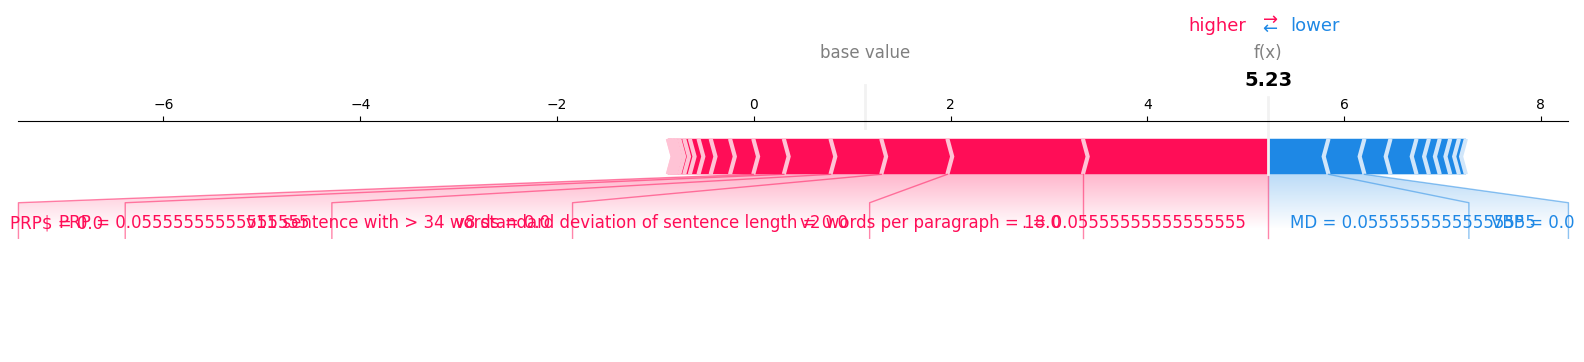

In [44]:
shap.force_plot(
    explainer.expected_value[1],  # type: ignore
    test_shap_val[0],
    result.test_data.iloc[0],
)
shap.force_plot(
    explainer.expected_value[1],  # type: ignore
    test_shap_val[0],
    result.test_data.iloc[0],
    matplotlib=True,
    show=False,
)
plt.savefig(
    PathUtil.SHAP_FIGURE_DIR.joinpath("inaugural", "shap_force_plot.svg"),
    bbox_inches="tight",
)
plt.show()
plt.clf()


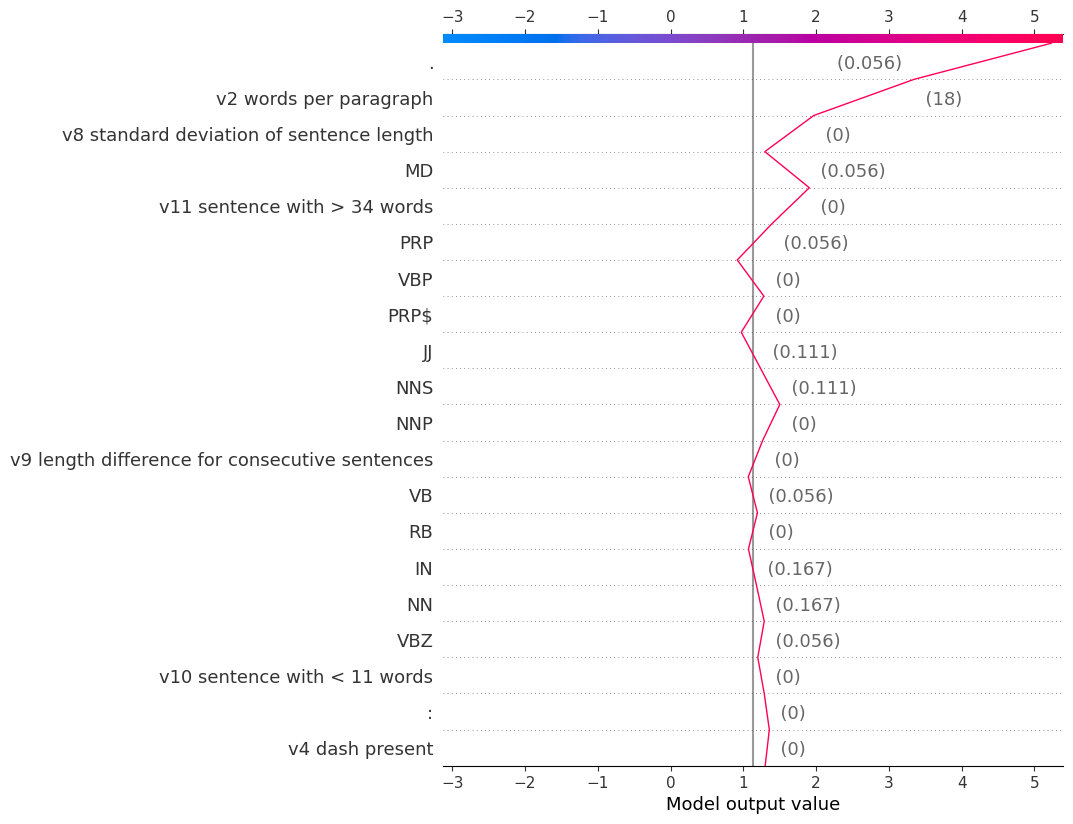

In [45]:
shap.decision_plot(
    explainer.expected_value[1],  # type: ignore
    test_shap_val[0],
    result.test_data.iloc[0],
    show=False,
)
plt.savefig(
    PathUtil.SHAP_FIGURE_DIR.joinpath("inaugural", "shap_decision_plot.svg"),
    bbox_inches="tight",
)
plt.show()
plt.clf()



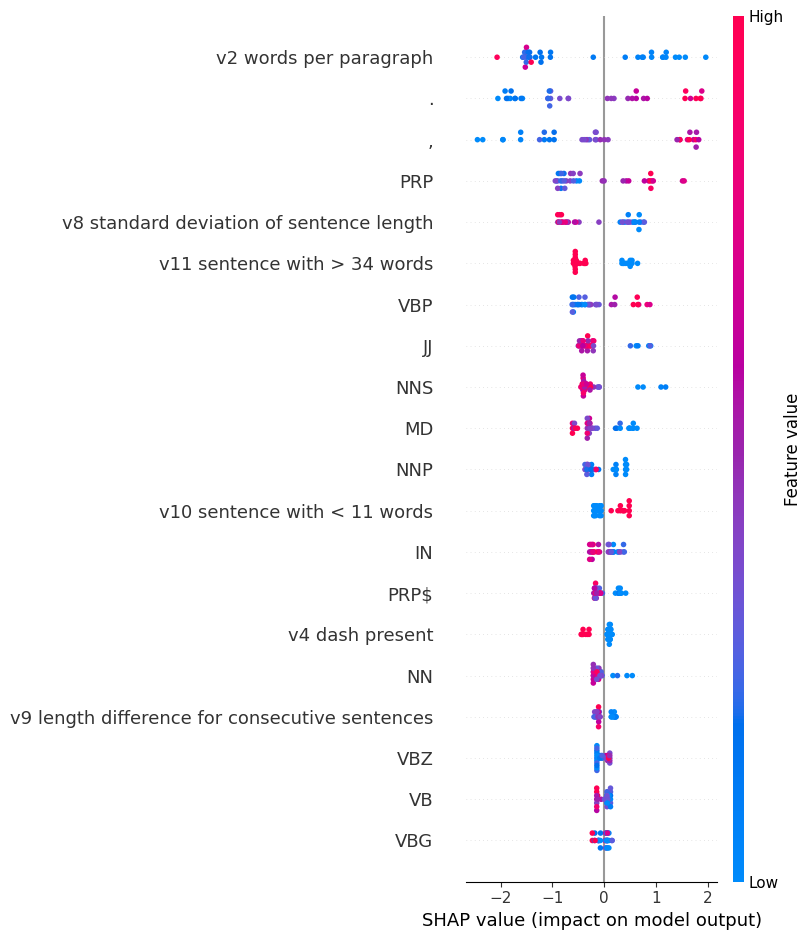

In [46]:
shap.summary_plot(
    test_shap_val,
    result.test_data,
    show=False,
)
plt.savefig(
    PathUtil.SHAP_FIGURE_DIR.joinpath("inaugural", "shap_summary_plot.svg"),
    bbox_inches="tight",
)
plt.show()
plt.clf()


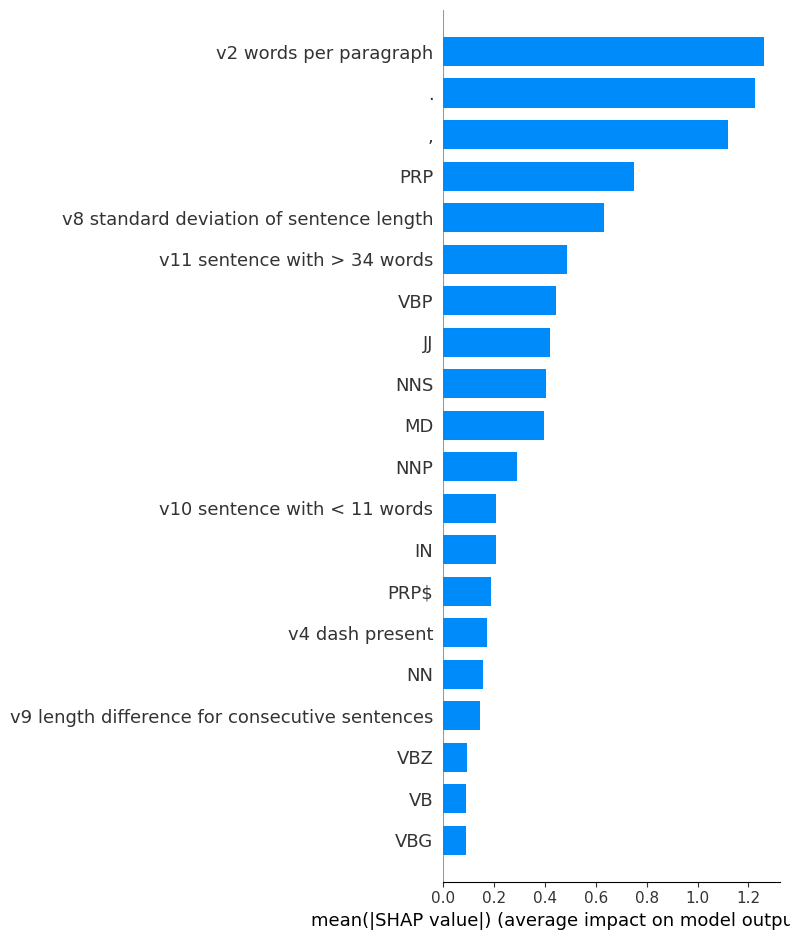

In [47]:
shap.summary_plot(
    test_shap_val,
    result.test_data,
    plot_type="bar",
    show=False,
)
plt.savefig(
    PathUtil.SHAP_FIGURE_DIR.joinpath("inaugural", "shap_summary_plot_bar.svg"),
    bbox_inches="tight",
)
plt.show()
plt.clf()
